In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 26 17:17:34 2020

"""
import numpy as np
import scipy
from scipy import interpolate
from scipy import optimize, io, linalg
import os
import xarray as xr
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import griddata

1. Import data
   path_nadir and path_SWOTpass on OSMOSIS1 domain are imported:

In [4]:
#### SWOT DATA
# Make sure to put this script in the directory below (/data/OSMOSIS/) before you run it

domain_name = 'OSMOSIS1'
addpath = '/home/hafolahbi/Desktop/INTERN/Work/SWOT_prac/data'
os.chdir(r'/home/hafolahbi/Desktop/INTERN/Work/SWOT_prac/data/OSMOSIS')

# Name of the SWOT pass in data/*domain*/ directory
if domain_name == 'OSMOSIS1' :
    path_SWOTpass = 'BOOST-SWOT_SWOT_OSMOSIS_c02_p436.nc'
    path_nadir = 'BOOST-SWOT_J1_nadir_c05_p01.nc'
    # Plotting params
    max_range = 0.2 # Limit for colorbar (SSH in meters) for SSH
    max_range_diff = 0.1 # Limit for colorbar (SSH in meters) for SSH differences

2. Then SWOT and Nadir paths are downloaded

In [10]:
#### Download a SWOT path

roll_error_only = True

all_but_karin = False

with xr.open_dataset(path_SWOTpass, mask_and_scale=True) as (ds_SWOTpass):
    ds_SWOTpass.info() # Dimension of the dataset
ntime = ds_SWOTpass.time.size
nc = ds_SWOTpass.nC.size
lon_swotpass = np.zeros([ntime, nc])
lon_swotpass [:,:] = ds_SWOTpass.lon
lon_swotpass = np.ma.masked_invalid(lon_swotpass)
lat_swotpass = np.zeros([ntime,nc])
lat_swotpass [:,:] = ds_SWOTpass.lat
lat_swotpass = np.ma.masked_invalid(lat_swotpass)
ssh_swotpass = np.zeros([ntime,nc])
if roll_error_only:
    ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err
elif all_but_karin:
   ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err + ds_SWOTpass.phase_err + ds_SWOTpass.timing_err + ds_SWOTpass.bd_err
else: 
    ssh_swotpass[:, :] = ds_SWOTpass.ssh_obs
ssh_swotpass = np.ma.masked_invalid(ssh_swotpass)
ssh_swotpass_truth = np.zeros([ntime, nc]) 
ssh_swotpass_truth[:, :] = ds_SWOTpass.ssh_model # ssh model
ssh_swotpass_truth = np.ma.masked_invalid(ssh_swotpass_truth)



xarray.Dataset {
dimensions:
	nC = 52 ;
	time = 597 ;

variables:
	float64 lon(time, nC) ;
		lon:units = deg ;
		lon:long_name = Longitude ;
		lon:valid_min = 0 ;
		lon:valid_max = 359999999 ;
	float64 lat(time, nC) ;
		lat:units = deg ;
		lat:long_name = Latitude ;
		lat:valid_min = -80000000 ;
		lat:valid_max = 80000000 ;
	float32 x_al(time, nC) ;
		x_al:units = km ;
		x_al:long_name = Along track distance from the beginning of the pass ;
	float32 x_ac(nC, time) ;
		x_ac:units = km ;
		x_ac:long_name = Across track distance from nadir ;
	float64 lon_nadir(time, nC) ;
		lon_nadir:units = deg ;
		lon_nadir:valid_min = 0 ;
		lon_nadir:valid_max = 359999999 ;
	float64 lat_nadir(time, nC) ;
		lat_nadir:units = deg ;
		lat_nadir:valid_min = -80000000 ;
		lat_nadir:valid_max = 80000000 ;
	float32 model_index(time, nC) ;
		model_index:valid_min = 0 ;
		model_index:valid_max = 65535 ;
		model_index:units =  ;
		model_index:long_name = Equivalent model output number in list of file ;
	float64 

In [ ]:
#### Download NADIR path
with xr.open_dataset(path_nadir, mask_and_scale=True) as ds_nadirpass:
    ds_nadirpass.info()
ndtime = ds_nadirpass.time.size
lon_nadirpass = np.zeros([ndtime])
lon_nadirpass[:] = ds_nadirpass.lon
lat_nadirpass = np.zeros([ndtime])
lat_nadirpass[:] = ds_nadirpass.lat
x_al = np.zeros([ndtime])
x_al[:] = ds_nadirpass.x_al
ssh_nadir = np.zeros([ndtime])  
            
ssh_nadir[:] = ds_nadirpass.ssh_obs
ssh_nadir_truth = np.zeros([ndtime])  
ssh_nadir_truth[:] = ds_nadirpass.ssh_model


3. SSH along nadir track (x_al) for Nadir data

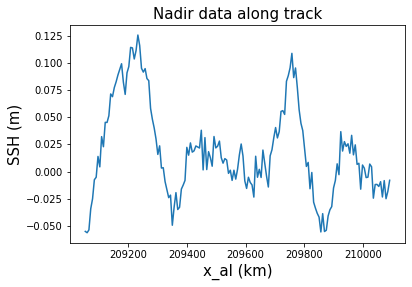

In [11]:
### SSH(m) vs Nadir along track (x_al) for Nadir data
plt.figure()
plt.plot(x_al,ssh_nadir)
plt.ylabel('SSH (m)',fontsize=15)
plt.xlabel('x_al (km)',fontsize=15)
plt.title('Nadir data along track', fontsize=15)
plt.show()

# INTERPOLATION

In [20]:
#%%
## To interpolate SWOT data into the Nadir line
#interp = interp1d(ssh_nadir,ssh_nadir_truth, kind='linear', fill_value='extrapolate') # 
linear_interp = interp2d(lon_swotpass,lat_swotpass,ssh_swotpass, kind='linear', fill_value='extrapolate')

# But what is needed a protion of nadir ssh that cut swot ssh 
####Another way
#grid_x, grid_y = np.mgrid[0:100:100j, 0:100:200j]
#grid_z0 = griddata(ssh_swotpass, ssh_nadir, (grid_x, grid_y), method='linear')

/home/hafolahbi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=178,179 m=31044 fp=nan s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [26]:
### select SSH data along the track (x_al)

def SWOT_along_x_al (lon_nadirpass,lat_nadirpass,lon_swotpass,lat_swotpass,ssh_swotpass,ndtime,ntime,nc):
    ssh_swotxal=np.zeros([ndtime])
    for i in range (0,ntime+1):
        for j in range (0,nc+1):
            for k in range (0,ndtime+1):
                if lon_nadirpass[k]==lon_swotpass[i,j] and lat_nadirpass[k]==lat_swotpass[i,j]:
                    ssh_swotxal[k]=ssh_swotpass[i,j]
    return (ssh_swotxal)

In [17]:
interp

In [23]:
linear_interp

In [27]:
lon_swotpass

masked_array(
  data=[[342.011232, --, --, ..., --, --, --],
        [342.02214399999997, 342.05152, 342.0808, ..., --, --, --],
        [342.03308799999996, 342.062368, 342.09168, ..., --, --, --],
        ...,
        [--, --, --, ..., 348.508064, 348.53270399999997, 348.557376],
        [--, --, --, ..., 348.514272, 348.53894399999996, 348.563584],
        [--, --, --, ..., --, 348.545216, 348.569888]],
  mask=[[False,  True,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ...,  True, False, False]],
  fill_value=1e+20)

In [39]:
linear_interp